In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
import seaborn as sns
import argparse
import cv2
import os


In [2]:
data_dir = "D:\DatasetsCD\Project_covid_2020_multiclass_newdataset"

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)


In [3]:
dataset.class_to_idx


{'COVID': 0, 'NORMAL': 1, 'Pneumonia': 2}

In [4]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{0: 'COVID', 1: 'NORMAL', 2: 'Pneumonia'}

In [5]:
def get_class_distribution(dataset_obj):
    
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
    
    return count_dict

print("Distribution of classes: \n", get_class_distribution(dataset))

Distribution of classes: 
 {'COVID': 1200, 'NORMAL': 1341, 'Pneumonia': 1345}


In [ ]:
# 3886 , 777

In [13]:
## spliting dataset 80 % training,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(3108,778))

In [14]:
training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))


Length of the train_loader: 98
Length of the val_loader: 778


In [9]:
single_batch  = next(iter(training_loader))
print("dimension of bath :" ,single_batch[0].shape , "\noutput_label shape :  ",single_batch[1].shape)

dimension of bath : torch.Size([32, 3, 224, 224]) 
output_label shape :   torch.Size([32])


In [10]:
single_batch[1]

tensor([2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 2])

In [15]:
### peraparing GPU

device = torch.device("cuda:0")
device
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [16]:
##defining model res net 50

model = models.resnet50(pretrained=True).to(device) # freeze all the parameters except the final layer 
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.2),
               nn.Linear(128, 3)
               ).to(device)

In [13]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [14]:
def multi_acc(y_pred, y_test):
    
    y_pred_soft = torch.log_softmax(y_pred,dim = 1)
    _,ypred = torch.max(y_pred_soft, dim = 1)
    
    correct_pred_sum = (ypred == y_test).sum().float()
    acc = correct_pred_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc

In [15]:
from tqdm import tqdm


accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 7


for epoch in tqdm(range(Epochs)):
    
    train_epoch_loss = 0
    val_epoch_loss = 0
    
    
    train_epoch_acc = 0
    val_epoch_acc = 0
    
    model.train()
    for x_train_batch, y_train_batch in training_loader:
        
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        output = model(x_train_batch)
        
        loss_train = criterion(output,y_train_batch)
        train_acc = multi_acc(output,y_train_batch)
        
        loss_train.backward()
        optimizer.step()
        
        train_epoch_loss +=loss_train.item()  ## sum loss over all batches for each epoch  
        train_epoch_acc += train_acc.item()
        
    #### validation 
    
    with torch.no_grad():
        model.eval()
        
        for x_val_batch, y_val_batch in val_loader:
            
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            
            val_output = model(x_val_batch)
            val_output = torch.unsqueeze(val_output, 0)
            
            val_loss = criterion(val_output, y_val_batch)
            val_acc = multi_acc(val_output, y_val_batch)
    
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

 14%|███████████▊                                                                       | 1/7 [02:25<14:31, 145.17s/it]

Epoch: 0| train-loss: 0.3738479368692758| val-loss: 0.19156736696850973 | train_accuracy : 86.42857142857143 | val_accuracy : 93.70179948586119 


 29%|███████████████████████▋                                                           | 2/7 [04:00<10:50, 130.08s/it]

Epoch: 1| train-loss: 0.20740084447042675| val-loss: 0.20683657116957868 | train_accuracy : 92.88775510204081 | val_accuracy : 93.44473007712082 


 43%|███████████████████████████████████▌                                               | 3/7 [05:35<07:58, 119.57s/it]

Epoch: 2| train-loss: 0.1890155002094653| val-loss: 0.15109411402262313 | train_accuracy : 93.57142857142857 | val_accuracy : 95.11568123393316 


 57%|███████████████████████████████████████████████▍                                   | 4/7 [07:13<05:39, 113.28s/it]

Epoch: 3| train-loss: 0.2021916299602207| val-loss: 0.13706116583477598 | train_accuracy : 92.61224489795919 | val_accuracy : 94.8586118251928 


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [08:51<03:37, 108.60s/it]

Epoch: 4| train-loss: 0.17962687721057813| val-loss: 0.14568605898336082 | train_accuracy : 94.03061224489795 | val_accuracy : 94.47300771208226 


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [10:28<01:45, 105.11s/it]

Epoch: 5| train-loss: 0.16408709877607774| val-loss: 0.13766540644678898 | train_accuracy : 94.61224489795919 | val_accuracy : 95.37275064267352 


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [12:09<00:00, 104.22s/it]

Epoch: 6| train-loss: 0.1714743356771615| val-loss: 0.13022656981251426 | train_accuracy : 93.96938775510205 | val_accuracy : 95.62982005141389 


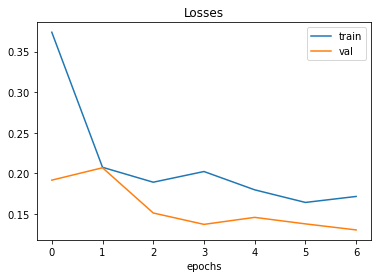

In [16]:
for v,c in sorted(loss_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('Losses')
plt.legend()
plt.show()

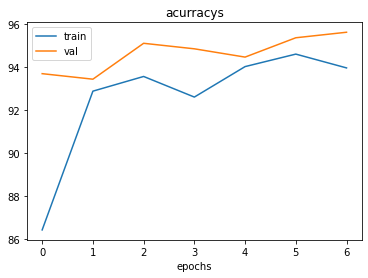

In [17]:
for v,c in sorted(accuracy_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('acurracys')
plt.legend()
plt.show()  

In [18]:

torch.save(model.state_dict(), 'model_weights_multiclass_resnet.pth')


In [5]:
model.load_state_dict(torch.load('model_weights_multiclass_resnet.pth'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
#preparing test data 
data_dir = "D:\DatasetsCD\Test_set_Multiclasse"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 


In [7]:
dataset2.class_to_idx

{'COVID': 0, 'NORMAL': 1, 'Pneumonia': 2}

In [8]:
len(test_loader)

854

In [9]:
y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        
        y_pred_soft = torch.log_softmax(y_test_pred,dim = 1)
        _, y_pred = torch.max(y_pred_soft,dim = 1)
       
        y_predicted.append(y_pred.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())

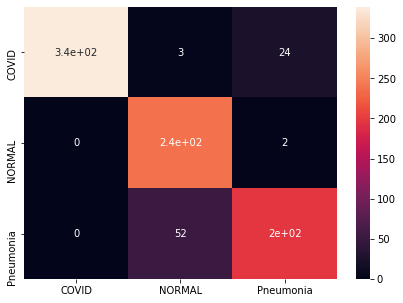

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [14]:
print(classification_report(y_predicted, y_true, target_names=['Covid 0', 'NORMAL 1', 'Pneumonia 2']))

              precision    recall  f1-score   support

     Covid 0       0.93      1.00      0.96       339
    NORMAL 1       0.99      0.81      0.89       293
 Pneumonia 2       0.79      0.88      0.83       222

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.91      0.91      0.90       854

